### Laboratory work 2 - Comparison of the exponential and running mean for random walk model
#### Nikolay Zherdev, Dmitry Baluev, Carolina Latserus
#### Skoltech, 08.10.2018

The goal of this laboratory work is to compare performance of exponential and running mean for random walk model.

This lab consists of two parts:

I. Determination of optimal smoothing constant in the exponential mean.

II. Comparison of methodical errors of the exponential and running mean.

In [66]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

# Part 1

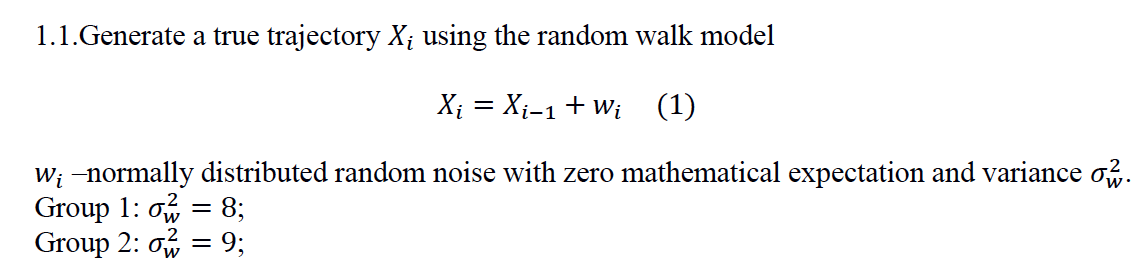

In [67]:
def generate_trajectory(x0 = 10, mean = 0, var = 0.1, steps = 100):
    trajectory = np.random.normal(loc = mean, scale = np.sqrt(var), size = steps)
    trajectory[0] = x0
    return np.cumsum(trajectory)

In [68]:
traj3000 = generate_trajectory(var = 9, steps = 3000)
traj300 = traj3000[:300]

In [69]:
data = [
    go.Scatter(
        y=traj3000,
        name='trajectory 1'
    ),
    go.Scatter(
        y=traj300,
        name='trajectory 2'
    ),
]

layout= go.Layout(
    title= 'Trajectories',
    xaxis= dict(
        title= 'Steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

In [70]:
def measure(trajectory, mean = 0, var = 0.1):
    noise = np.random.normal(loc = mean, scale = np.sqrt(var), size = trajectory.shape)
    return np.add(trajectory, noise)

In [71]:
meaz300 = measure(traj300, var = 12)
meaz3000 = measure(traj3000, var = 12)

In [72]:
data = [
    go.Scatter(
        y=traj300,
        name='trajectory 300'
    ),
    go.Scatter(
        y=meaz300,
        name='measurment 300'
    ),
]

layout= go.Layout(
    title= 'True and measured',
    xaxis= dict(
        title= 'Steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

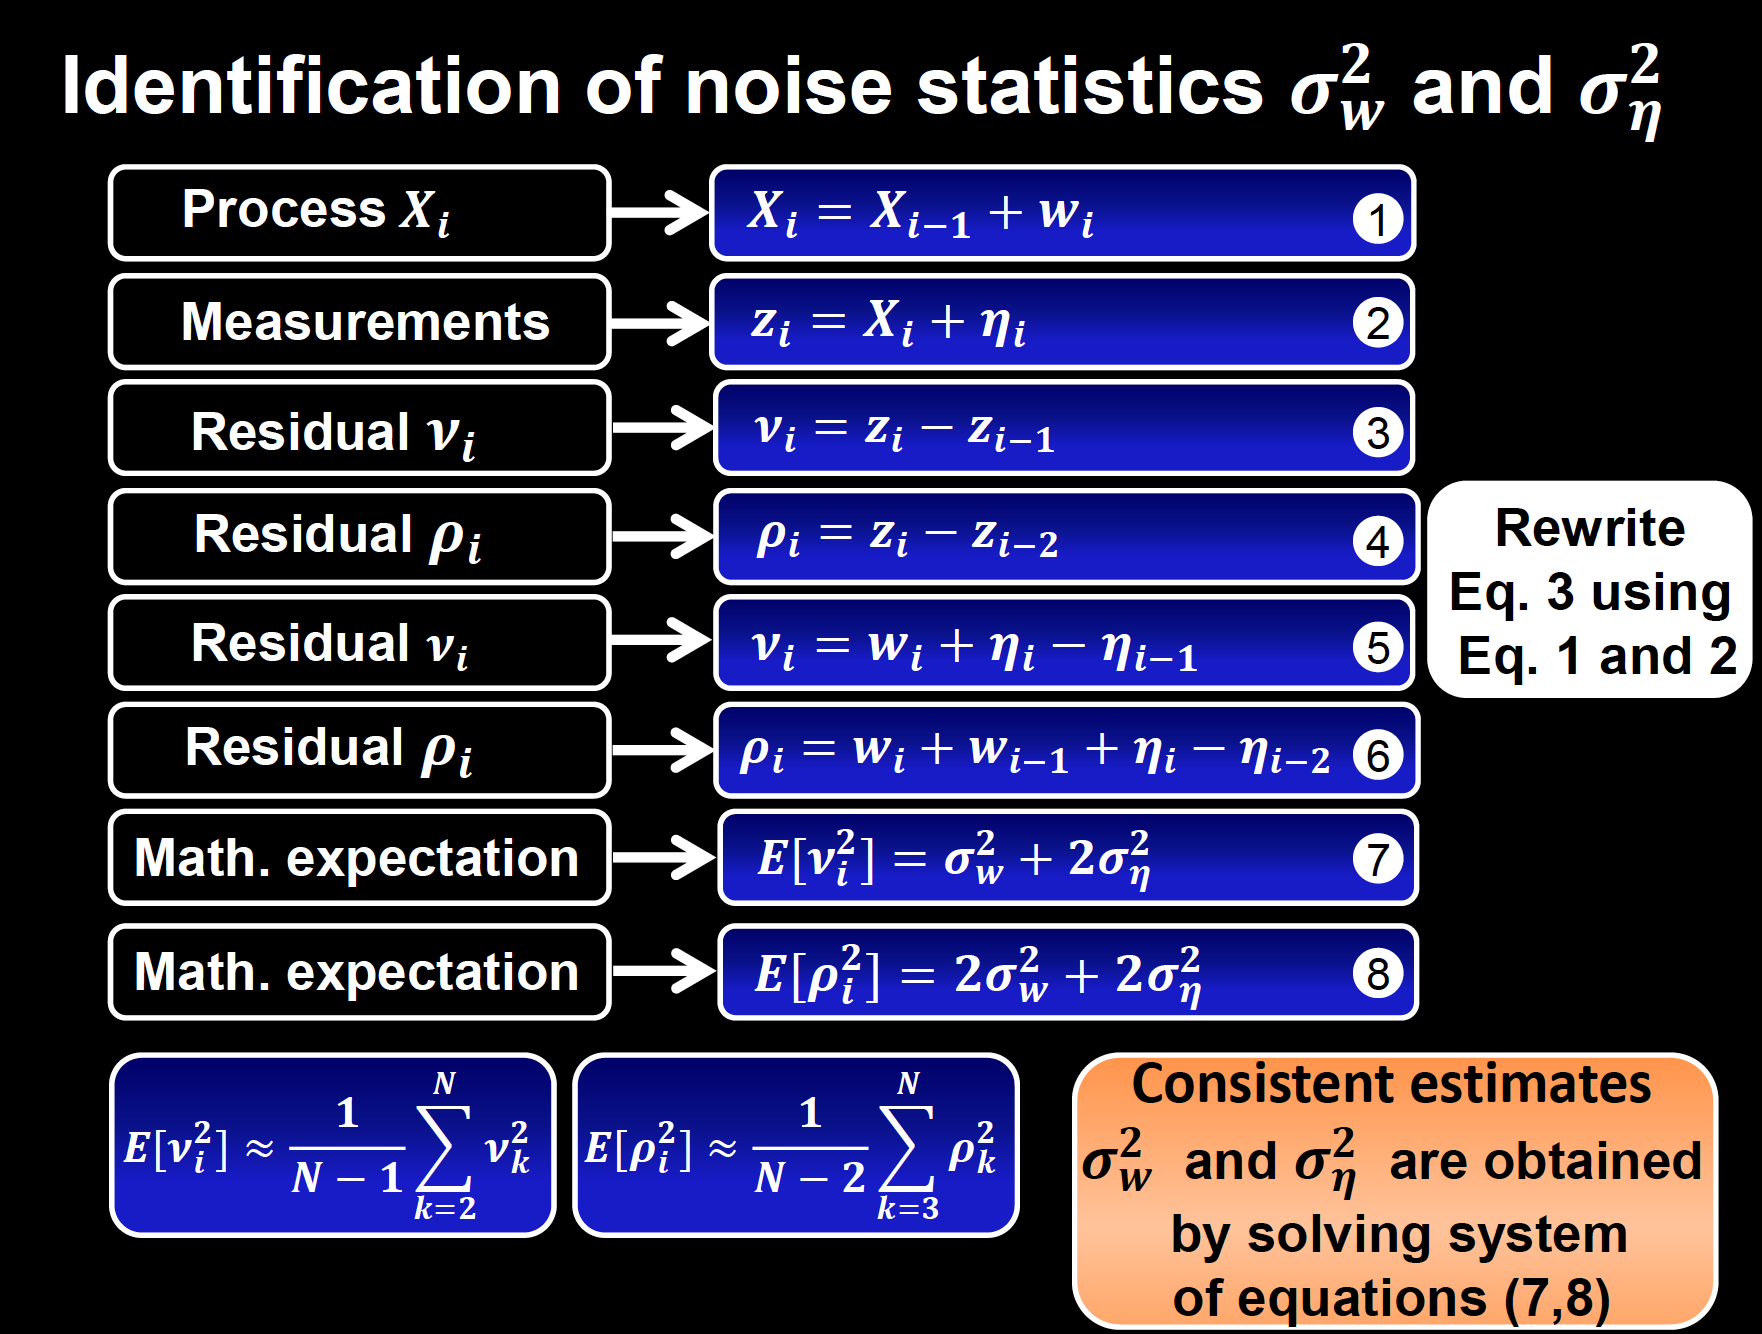

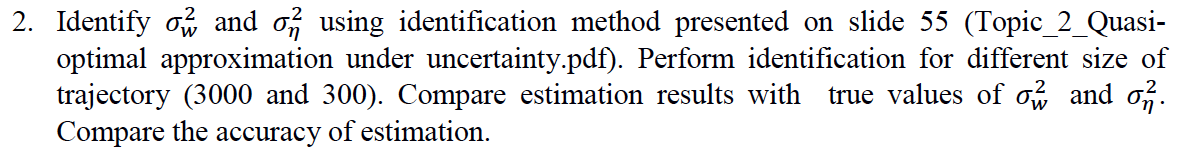

In [113]:
def variations(z):
    vi = np.subtract(z[1:], z[:-1])
    pi = np.subtract(z[2:], z[:-2])
    E_v = np.mean(vi**2)
    E_p = np.mean(pi**2)
    a = np.array([[1, 2],[2, 2]])
    b = np.array([E_v, E_p])
    return np.linalg.solve(a, b) # solve for var_w, var_n

# np.allclose(np.dot(a, x), b)

In [114]:
var_w, var_n = variations(meaz300)
print("var_w is", float("{:.2f}".format(var_w)))
print("var_n is", float("{:.2f}".format(var_n)))
print("ref values are", 9, "and", 12, "correspondingly")

var_w is 9.58
var_n is 8.19
ref values are 9 and 12 correspondingly


In [115]:
var_w, var_n = variations(meaz3000)
print("var_w is", float("{:.2f}".format(var_w)))
print("var_n is", float("{:.2f}".format(var_n)))
print("ref values are", 9, "and", 12, "correspondingly")

var_w is 9.52
var_n is 11.87
ref values are 9 and 12 correspondingly


On a small dataset the estimated variances differ greatly from table values, but for increased dataset their values became much closer to the real ones.

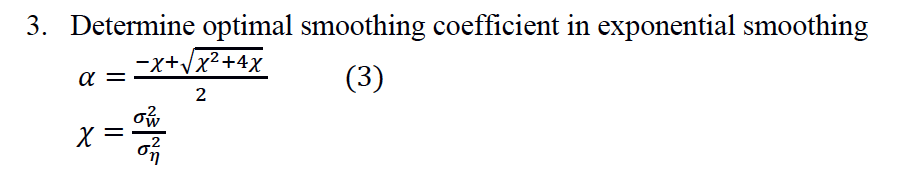

In [116]:
def smoothing_coeff(var_w, var_n):
    xi = var_w / var_n
    return (-xi + np.sqrt(xi**2 + 4*xi))/2

In [117]:
opt_alpha = smoothing_coeff(var_w, var_n)
print("optimum alpha is", float("{:.2f}".format(opt_alpha)))

optimum alpha is 0.58


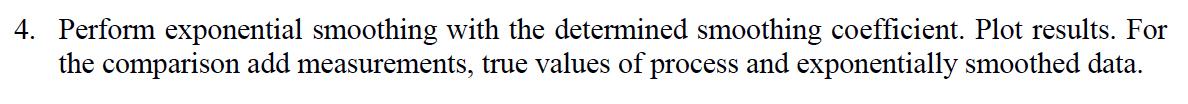

In [78]:
def exp_smooth(z, alpha):
    X = np.zeros(z.shape)
    X[0] = z[0]
    for i in range(1, z.shape[0]):
        X[i] = X[i-1] + alpha*(z[i] - X[i-1])
    return X

In [79]:
smooth300 = exp_smooth(meaz300, opt_alpha)

In [105]:
data = [
    go.Scatter(
        y=traj300,
        name='trajectory'
    ),
    go.Scatter(
        y=meaz300,
        name='measurment'
    ),
    go.Scatter(
        y=smooth300,
        name='exp_smoothing'
    ),
]

layout= go.Layout(
    title= 'True, measured and exp-smoothed',
    xaxis= dict(
        title= 'Steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

# Part 2

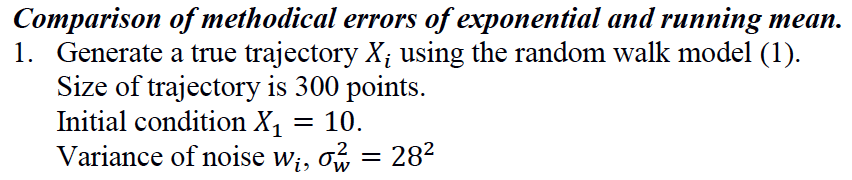

In [118]:
trajectory = generate_trajectory(x0 = 10, var = 28**2, steps = 300)

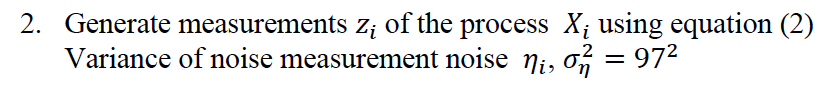

In [119]:
measurments = measure(trajectory, var = 97**2)

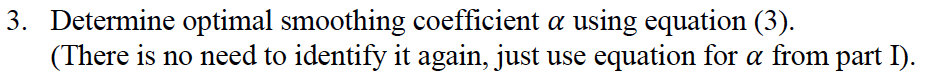

In [122]:
var_w, var_n = 28**2, 97**2

# apply EM with alpha to measurments
alpha = smoothing_coeff(var_w, var_n)
exp_smoothed = exp_smooth(measurments, alpha)
print("optimum alpha is", float("{:.2f}".format(alpha)))


optimum alpha is 0.25


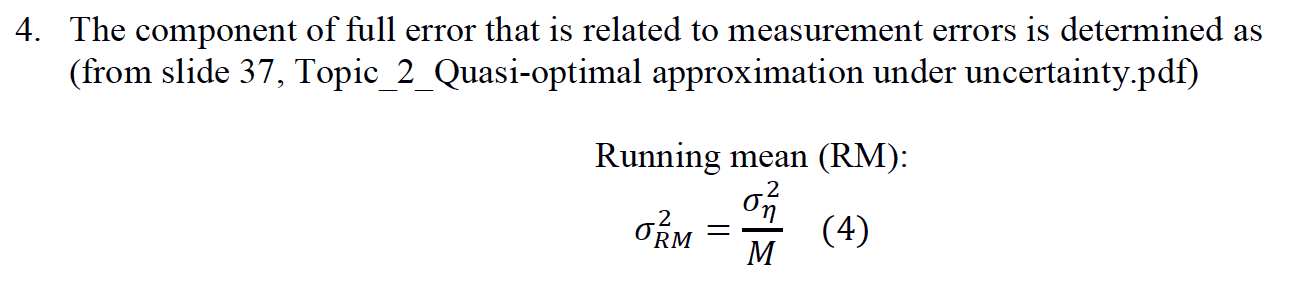

In [123]:
M = (2-alpha)/alpha

In [124]:
M

7.000364422000923

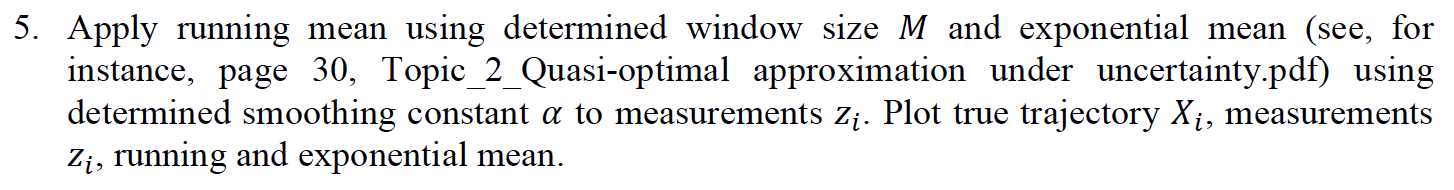

In [125]:
# apply RM with window M to measurments

running_mean = pd.Series(measurments).rolling(window=int(M), center = True).mean()

In [126]:
data = [
    go.Scatter(
        y=trajectory,
        name='trajectory'
    ),
    go.Scatter(
        y=measurments,
        name='measurments'
    ),
    go.Scatter(
        y=exp_smoothed,
        name='exp_smoothed'
    ),
    go.Scatter(
        y=running_mean,
        name='running_mean'
    ),
]

layout= go.Layout(
    title= 'True, measured and smoothed',
    xaxis= dict(
        title= 'Steps',
    ),
    yaxis=dict(
        title= 'X',
    ),
    showlegend= True
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

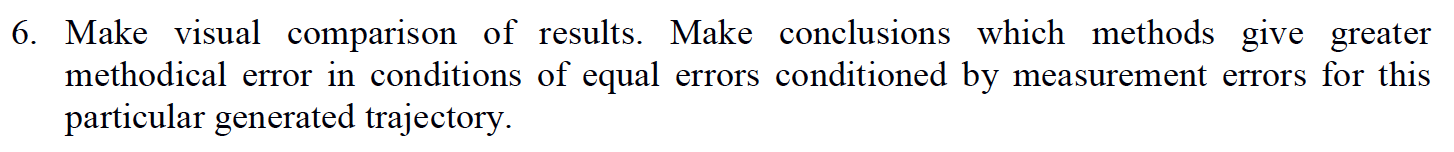

In [127]:
# Determine the variance of deviation of smoothed data from the true one.
RM_error = running_mean - trajectory # running mean
ES_error = exp_smoothed - trajectory # exp smoothing

RM_var = np.var(RM_error, ddof = 1)
ES_var = np.var(ES_error, ddof = 1)

print("Running mean variance", float("{:.2f}".format(RM_var)))
print("Exp smoothing variance", float("{:.2f}".format(ES_var)))

Running mean variance 1873.31
Exp smoothing variance 2412.75


It was concluded that the method of exponential smoothing gives bigger time delay, than the method of running mean. By calculating variances of both methods we obtained exact result: Running mean performs more accurately.